In [1]:
import pandas as pd

import os

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import glob


import warnings
warnings.filterwarnings("ignore")

import matplotlib
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

import json

In [2]:
# Load configuration
with open("../../config/config_notebooks_TNBC.json", "r") as config_file:
    config = json.load(config_file)

a = config['retrained_color_palette']

In [3]:
# Retrieve patient names and loop through them
patient_list = [f"TNBC{i}" for i in range(1, 97)]

patients_to_remove = []
for patient in patient_list:
    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):
        for name in names:
            if os.path.exists(os.path.join(benchmark_path, "invasive_cancer_clustering", "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_5_clusters_patient_{patient}.csv")) == False:
                patients_to_remove.append(patient)
                print(f"Removed patient {patient} as file does not exist")

# remove all patients in patients_to_remove from patient_list
patients_to_remove_set = set(patients_to_remove)
original_len = len(patient_list)
patient_list = [p for p in patient_list if p not in patients_to_remove_set]
print(f"Removed {original_len - len(patient_list)} patients; remaining {len(patient_list)} patients.")

Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC10 as file does not exist
Removed patient TNBC17 as file does not exist
Removed patient TNBC17 as file does not exist
Removed patient TNBC17 as file does not exist
Removed patient TNBC17 as file does not exist
Removed patient TNBC17 as file does not exist
Removed patient TNBC17 as file does not exist
Removed patient TNBC17 as file does not exist
Removed patient TNBC17 as file doe

In [5]:
optimal_clusters = []
df_all_summary = []
for i_p, patient in enumerate(patient_list):

    df_summary = pd.DataFrame(columns=["n_clusters", 
                                    "wasserstein_distances", 
                                    "mean_wasserstein_distance", 
                                    "std_wasserstein_distance", 
                                    "median_wasserstein_distance", 
                                    "min_wasserstein_distance", 
                                    "max_wasserstein_distance",
                                    "model_type",
                                    "params"])
    summary_list = []
    all_names = []
    wassersteins = []

    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):

        
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
        dfs = []
        optimal_clusters.append(opti_clusters)
        


        for name in names:

            filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_5_clusters_patient_{patient}.csv")

            # print(filename)
            df = pd.read_csv(filename, index_col=0)

            n_clusters = df.shape[0]
            
            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
            wasserstein_distances = lower_matrix.stack().values
            wassersteins.append(wasserstein_distances)

            if len(wasserstein_distances) == 0:
                mean_wasserstein_distance = np.nan
                std_wasserstein_distance = np.nan
                median_wasserstein_distance = np.nan
                min_wasserstein_distance = np.nan
                max_wasserstein_distance = np.nan
            else:
                mean_wasserstein_distance = np.mean(wasserstein_distances)
                std_wasserstein_distance = np.std(wasserstein_distances)
                median_wasserstein_distance = np.median(wasserstein_distances)

                min_wasserstein_distance = np.min(wasserstein_distances)
                max_wasserstein_distance = np.max(wasserstein_distances)

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            summary_list.append({"n_clusters": n_clusters, 
                                "wasserstein_distances": wasserstein_distances, 
                                "mean_wasserstein_distance": mean_wasserstein_distance, 
                                "std_wasserstein_distance": std_wasserstein_distance, 
                                "median_wasserstein_distance": median_wasserstein_distance, 
                                "min_wasserstein_distance": min_wasserstein_distance, 
                                "max_wasserstein_distance": max_wasserstein_distance,
                                "model_type": model_type, 
                                "params": params})
            
            if name == "uni":
                name = f"uni_{model_type}"

            dfs.append(df)
            all_names.append(name)


    df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
    df_summary.index = all_names
    df_summary['patient'] = patient
    df_all_summary.append(df_summary)




    df_sink = pd.DataFrame(wassersteins, index=all_names).T
    df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
    df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
    df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")

df_spider = pd.concat(df_all_summary).reset_index().rename(columns={"index": "model"})

## Mean wasserstein distance per patient
stat = 'median'
# plt.figure(figsize=(8, 7))
# sns.barplot(df_spider, x="params", y=f"{stat}_wasserstein_distance", hue='model_type', palette={"full": "black", "explora": "lightgrey"})
# plt.xticks(rotation=90)
# sns.despine()

# plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the combat_corrected embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
# #plt.yscale("log")
# plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"{stat}_wasserstein_distance_across_patients_in_combat_corrected_embedding.pdf"), bbox_inches='tight')

optimal_clusters = pd.concat(optimal_clusters).drop_duplicates()


In [6]:
optimal_clusters

,n_neighbors,data,labels,cluster_number,silhouette_score,inertia,davies_bouldin_score,calinski_harabasz_score,ARI_patient,n_clusters,min_dist,euclidian_dist_to_optimal,batch_effect_mitigation
name,,,,,,,,,,,,,
uni,100.0,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, ...",5.0,0.384981,109084.066906,0.851323,40155.222528,0.162210,5,0.001,0.636050,0.837790
uni_explora_kde_16384_prototypes,10.0,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, ...",5.0,0.403939,389728.233482,0.765332,45698.092329,0.152944,5,0.100,0.615370,0.847056
uni_explora_kde_4096_prototypes,300.0,umap,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, ...",5.0,0.397382,118980.100835,0.758625,45277.446304,0.163532,5,0.001,0.624412,0.836468
uni_explora_kde_65536_prototypes,350.0,umap,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",4.0,0.435319,136958.631246,0.678091,46401.320624,-0.035385,4,0.001,0.565789,1.035385
uni_explora_koleo_16384_prototypes,300.0,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, ...",5.0,0.416716,97221.825293,0.729674,46246.396084,0.019303,5,0.001,0.583603,0.980697
uni_explora_koleo_4096_prototypes,300.0,umap,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.0,0.419562,139228.819697,0.731658,37742.453400,0.136477,4,0.001,0.596267,0.863523
uni_explora_koleo_65536_prototypes,150.0,umap,"[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, ...",4.0,0.390535,154296.580638,0.776103,35194.714830,0.000208,4,0.001,0.609465,0.999792
uni,NaN,NaN,NaN,NaN,0.423326,NaN,NaN,NaN,0.289026,5,NaN,0.645050,NaN
uni_full_kde_16384_prototypes,NaN,NaN,NaN,NaN,0.460478,NaN,NaN,NaN,0.000482,6,NaN,0.539522,NaN


In [7]:
import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

retrained_models = config['retrained_model_list1'] + config['retrained_model_list2']
sorted_retrained_models = sort_retrained_models(retrained_models)

print("Original order:", retrained_models)
print("Sorted order:", sorted_retrained_models)


palette = []
for model in sorted_retrained_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

Original order: ['uni', 'uni_explora_kde_4096_prototypes', 'uni_explora_kde_16384_prototypes', 'uni_explora_kde_65536_prototypes', 'uni_explora_koleo_4096_prototypes', 'uni_explora_koleo_16384_prototypes', 'uni_explora_koleo_65536_prototypes', 'uni', 'uni_full_kde_4096_prototypes', 'uni_full_kde_16384_prototypes', 'uni_full_kde_65536_prototypes', 'uni_full_koleo_4096_prototypes', 'uni_full_koleo_16384_prototypes', 'uni_full_koleo_65536_prototypes']
Sorted order: ['uni', 'uni_explora_kde_4096_prototypes', 'uni_explora_kde_16384_prototypes', 'uni_explora_kde_65536_prototypes', 'uni_full_kde_4096_prototypes', 'uni_full_kde_16384_prototypes', 'uni_full_kde_65536_prototypes', 'uni_explora_koleo_4096_prototypes', 'uni_explora_koleo_16384_prototypes', 'uni_explora_koleo_65536_prototypes', 'uni_full_koleo_4096_prototypes', 'uni_full_koleo_16384_prototypes', 'uni_full_koleo_65536_prototypes']


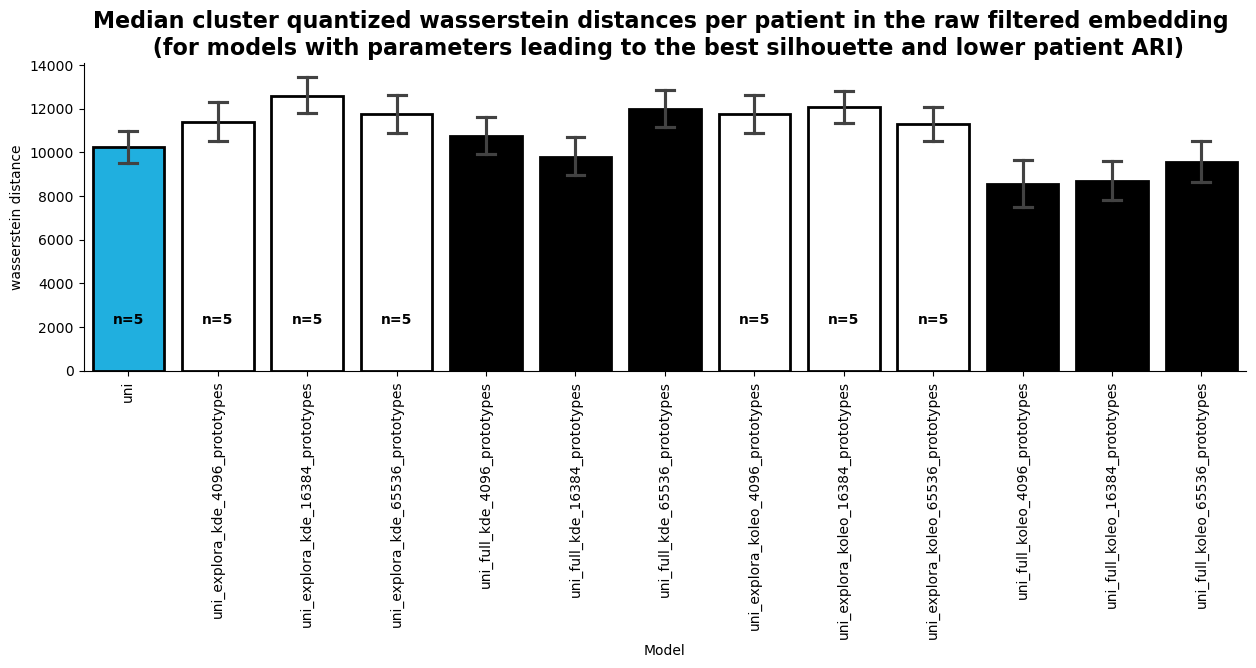

In [8]:
dfs = []
n_clusters = []
for model_type in sorted_retrained_models:
    if model_type == "uni":
        df = df_spider[df_spider['model'] == "uni_explora"]
        df['model'] = "uni"
    else:
        df = df_spider[df_spider['model'] == model_type]

    n_clusters.append(optimal_clusters.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', y="median_wasserstein_distance", 
palette=palette, 
# palette=["deepskyblue", "white", "white", "white","black", 
#           "black", "black", "white", "white", "white", 
#         "black", "black", "black", ],
                     linewidth=2,
            edgecolor="black", capsize=0.2
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the raw filtered embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
sns.despine()

for i, n in enumerate(n_clusters):
    # plt.text(x=i, y=13000, s=f"n={n}", ha='center', va='bottom', weight='bold')
    plt.text(x=i, y=2000, s=f"n=5", ha='center', va='bottom', weight='bold')




plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_raw filtered_embedding_per_patient.pdf"), bbox_inches='tight')

In [9]:
optimal_clusters = []
df_all_summary = []


for i_p, patient in enumerate(patient_list):

    df_summary = pd.DataFrame(columns=["n_clusters", 
                                    "wasserstein_distances", 
                                    "mean_wasserstein_distance", 
                                    "std_wasserstein_distance", 
                                    "median_wasserstein_distance", 
                                    "min_wasserstein_distance", 
                                    "max_wasserstein_distance",
                                    "model_type",
                                    "params"])
    summary_list = []
    all_names = []
    wassersteins = []


    for model_type, names, benchmark_path in zip([config['retrained_model_list1_type'],
                                  config['retrained_model_list2_type']],
                                  [config['retrained_model_list1'],
                                   config['retrained_model_list2']],
                                   [config['retrained_benchmark_folder1'],
                                    config['retrained_benchmark_folder2']]):

        
        
        path_to_invasive_cancer_clustering_results = os.path.join(benchmark_path, "invasive_cancer_clustering")
        opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", "optimal_clusters.csv"), index_col=0)
        dfs = []
        optimal_clusters.append(opti_clusters)
        
        


        for name in names:

            # print(f"model_type: {name}, optimal clusters: {opti_clusters.loc[name, 'n_clusters']}")

            
        # print(os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv"))
            # filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters_patient_{patient}.csv")
            filename = os.path.join(path_to_invasive_cancer_clustering_results, "kmeans", name, f"quantized_wasserstein_distance_molecular_combat_corrected_{name}_5_clusters_patient_{patient}.csv")

            # print(filename)
            df = pd.read_csv(filename, index_col=0)

            n_clusters = df.shape[0]
            
            # Get the lower triangular part of the matrix without the diagonal values
            lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
            wasserstein_distances = lower_matrix.stack().values
            wassersteins.append(wasserstein_distances)

            if len(wasserstein_distances) == 0:
                mean_wasserstein_distance = np.nan
                std_wasserstein_distance = np.nan
                median_wasserstein_distance = np.nan
                min_wasserstein_distance = np.nan
                max_wasserstein_distance = np.nan
            else:
                mean_wasserstein_distance = np.mean(wasserstein_distances)
                std_wasserstein_distance = np.std(wasserstein_distances)
                median_wasserstein_distance = np.median(wasserstein_distances)

                min_wasserstein_distance = np.min(wasserstein_distances)
                max_wasserstein_distance = np.max(wasserstein_distances)

            if name == "uni":
                params = "base"
            else:
                params = "_".join(name.split("_")[2:])

            summary_list.append({"n_clusters": n_clusters, 
                                "wasserstein_distances": wasserstein_distances, 
                                "mean_wasserstein_distance": mean_wasserstein_distance, 
                                "std_wasserstein_distance": std_wasserstein_distance, 
                                "median_wasserstein_distance": median_wasserstein_distance, 
                                "min_wasserstein_distance": min_wasserstein_distance, 
                                "max_wasserstein_distance": max_wasserstein_distance,
                                "model_type": model_type, 
                                "params": params})
            
            if name == "uni":
                name = f"uni_{model_type}"

            dfs.append(df)
            all_names.append(name)


    df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
    df_summary.index = all_names
    df_summary['patient'] = patient
    df_all_summary.append(df_summary)




    df_sink = pd.DataFrame(wassersteins, index=all_names).T
    df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
    df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
    df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


df_spider = pd.concat(df_all_summary).reset_index().rename(columns={"index": "model"})

## Mean wasserstein distance per patient
# stat = 'median'
# plt.figure(figsize=(8, 7))
# sns.barplot(df_spider, x="params", y=f"{stat}_wasserstein_distance", hue='model_type', palette={"full": "black", "explora": "lightgrey"})
# plt.xticks(rotation=90)
# sns.despine()

# plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the combat_corrected embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
# #plt.yscale("log")
# plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"{stat}_wasserstein_distance_across_patients_in_combat_corrected_embedding.pdf"), bbox_inches='tight')

optimal_clusters = pd.concat(optimal_clusters).drop_duplicates()

stat = 'median'



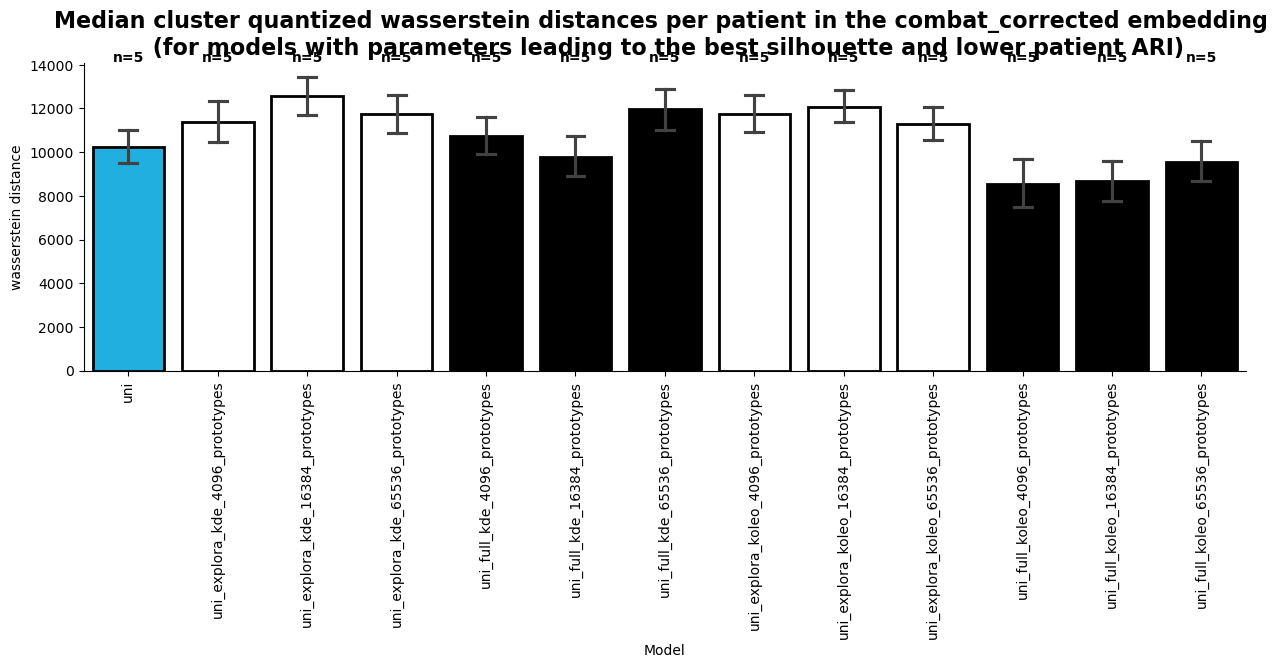

In [10]:
dfs = []
n_clusters = []
for model_type in sorted_retrained_models:
    if model_type == "uni":
        df = df_spider[df_spider['model'] == "uni_explora"]
        df['model'] = "uni"
    else:
        df = df_spider[df_spider['model'] == model_type]

    n_clusters.append(optimal_clusters.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', y="median_wasserstein_distance", 
palette=palette, 
                     linewidth=2,
            edgecolor="black", capsize=0.2
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"{stat.capitalize()} cluster quantized wasserstein distances per patient in the combat_corrected embedding \n (for models with parameters leading to the best silhouette and lower patient ARI)", weight='bold', fontsize=16)
sns.despine()

for i, n in enumerate(n_clusters):
    # plt.text(x=i, y=12000, s=f"n={n}", ha='center', va='bottom', weight='bold')
    plt.text(x=i, y=14000, s=f"n=5", ha='center', va='bottom', weight='bold')



plt.savefig(os.path.join(config['figures_folder'], "Figure4", f"quantized_wasserstein_between_image_clusters_in_combat_corrected_embedding_per_patient.pdf"), bbox_inches='tight')

In [11]:
df_summary = pd.DataFrame(columns=["n_clusters", 
                                   "wasserstein_distances", 
                                   "mean_wasserstein_distance", 
                                   "std_wasserstein_distance", 
                                   "median_wasserstein_distance", 
                                   "min_wasserstein_distance", 
                                   "max_wasserstein_distance",
                                   "model_type",
                                   "params"])
summary_list = []
all_names = []
wassersteins = []
optimal_clusters = pd.DataFrame()
for model_type, names, path in zip([config['retrained_model_list1_type'],
                             config['retrained_model_list2_type']],
                             [config['retrained_model_list1'],
                              config['retrained_model_list2']],
                              [config['retrained_benchmark_folder1'],
                               config['retrained_benchmark_folder2']]):
    
    path_to_invasive_cancer_clustering_results = os.path.join(path, "invasive_cancer_clustering", config['invasive_cancer_clustering_algo'])
    opti_clusters = pd.read_csv(os.path.join(path_to_invasive_cancer_clustering_results, "optimal_clusters.csv"), index_col=0)
    dfs = []

    
    


    for name in names:
        # print(os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_{opti_clusters.loc[name, 'n_clusters']}_clusters.csv"))
        filename = os.path.join(path_to_invasive_cancer_clustering_results, name, f"quantized_wasserstein_distance_{name}_molecular_combat_corrected_5_clusters.csv")
        df = pd.read_csv(filename, index_col=0)

        n = opti_clusters.loc[name, 'n_clusters']
        optimal_clusters.loc[name, 'n_clusters'] = n

        n_clusters = df.shape[0]      
        # Get the lower triangular part of the matrix without the diagonal values
        lower_matrix = df.where(np.tril(np.ones(df.shape), k=-1).astype(bool))
        wasserstein_distances = lower_matrix.stack().values
        wassersteins.append(wasserstein_distances)


        mean_wasserstein_distance = np.mean(wasserstein_distances)
        std_wasserstein_distance = np.std(wasserstein_distances)
        median_wasserstein_distance = np.median(wasserstein_distances)

        min_wasserstein_distance = np.min(wasserstein_distances)
        max_wasserstein_distance = np.max(wasserstein_distances)

        if name == "uni":
            params = "base"
        else:
            params = "_".join(name.split("_")[2:])

        summary_list.append({"n_clusters": n_clusters, 
                            "wasserstein_distances": wasserstein_distances, 
                            "mean_wasserstein_distance": mean_wasserstein_distance, 
                            "std_wasserstein_distance": std_wasserstein_distance, 
                            "median_wasserstein_distance": median_wasserstein_distance, 
                            "min_wasserstein_distance": min_wasserstein_distance, 
                            "max_wasserstein_distance": max_wasserstein_distance,
                            "model_type": model_type, 
                            "params": params})
        
        if name == "uni":
            name = f"uni_{model_type}"

        dfs.append(df)
        all_names.append(name)

df_summary = pd.concat([df_summary, pd.DataFrame(summary_list)], ignore_index=True)
df_summary.index = all_names




df_sink = pd.DataFrame(wassersteins, index=all_names).T
df_sink_melted = df_sink.melt(var_name="model", value_name="wasserstein_distance")
df_sink_melted['model_type'] = df_sink_melted['model'].apply(lambda x: x.split("_")[1])
df_sink_melted['param'] = df_sink_melted['model'].apply(lambda x: "_".join(x.split("_")[2:]) if len(x.split("_")) > 2 else "base")


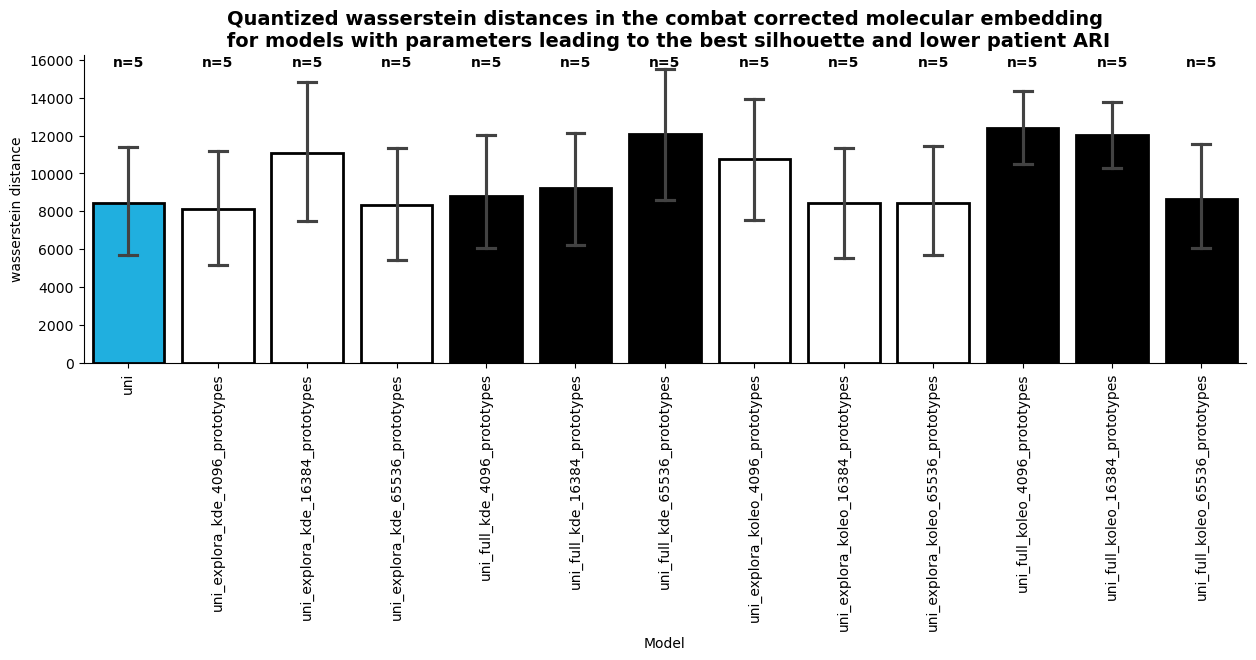

In [12]:
dfs = []
n_clusters = []

import sys
sys.path.append("../../")
from digitalhistopathology.notebooks_utils import sort_retrained_models

sorted_models = sort_retrained_models(config['retrained_model_list1'] + config['retrained_model_list2'])
for model_type in sorted_models:
    if model_type == "uni":
        df = df_sink_melted[df_sink_melted['model'] == "uni_explora"]
        df['model'] = "uni"
        n_clusters.append(df_summary.loc['uni_explora', 'n_clusters'])
    else:
        df = df_sink_melted[df_sink_melted['model'] == model_type]
        n_clusters.append(df_summary.loc[model_type, 'n_clusters'])
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)


palette = []
for model in sorted_models:
    if "explora" in model:
        palette.append("white")
    elif "full" in model:
        palette.append("black")
    else:
        palette.append("deepskyblue")

plt.figure(figsize=(15, 4))
sns.barplot(data=df, x='model', 
            y="wasserstein_distance", 
            palette=palette, 
            linewidth=2,
            edgecolor="black",
            capsize=0.2,
)
plt.xticks(rotation=90)
plt.ylabel("wasserstein distance")
plt.xlabel("Model")
plt.title(f"Quantized wasserstein distances in the combat corrected molecular embedding\n for models with parameters leading to the best silhouette and lower patient ARI", weight="bold", fontsize=14)
sns.despine()

for i, n in enumerate(n_clusters):
    plt.text(x=i, y=15500, s=f"n=5", ha='center', va='bottom', weight='bold')

plt.savefig(os.path.join(config['figures_folder'], "Figure4/invasive_cancer_clustering_quantized_wasserstein_distances_molecular_combat_corrected_embedding_for_clusters_defined_with_best_silhouette_and_lower_ARI_patient.pdf"), bbox_inches="tight")
